# Trajectory Batch Post-Analysis — Documentation

## Purpose
Aggregate per-trajectory metrics CSVs. Compute run-level summaries. Estimate scattering probability. Plot global distributions and correlations.

---

## Inputs
- **Directory:** `base_dir = example: "Normal_300K_01eV_results"`
- **File pattern:** chosen by `format`
  - `format = "LAMMPS"` → `pattern = "nve_*_metrics.csv"`
  - `format = "VASP"`   → `pattern = "vasprun-*_*metrics.csv"`
- **Per-file schema** (subset used):
  - `t_idx`
  - `COM_z-ztop(Å)`
  - `d_NO(Å)`
  - `Ecm(eV)`, `Evib_tot(eV)`, `Erot(eV)`
  - `Vcm_x(Å/fs)`, `Vcm_y(Å/fs)`, `Vcm_z(Å/fs)`
  - optional `outcome` or `output` (0/1 flags)

---

## Parameters
- `scatter_z = 7.0` Å. Height threshold for geometric scatter fallback.
- `roll_window = 25`. Smoothing window (prepared, not applied in plots).
- `total_mass_amu = None`. If set (e.g., `30.006` for NO), enables kinetic energy fallback from velocities.

---



In [12]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm as tqdm
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, tqdm
#sns.set(style="whitegrid", context="talk", font_scale=1.1)

specify_mpl_style = True
if specify_mpl_style:
    plt.style.use("/Users/samuel/Desktop/postdoc_PhLAM/codes/mystyle.mplstyle")

import matplotlib.style as mplstyle
mplstyle.use('fast') #The fast style set simplification and chunking parameters to reasonable settings to speed up plotting large amounts of data



Bad key legend.ncol in file /Users/samuel/Desktop/postdoc_PhLAM/codes/mystyle.mplstyle, line 37 ('legend.ncol: 1')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


In [13]:
# %% User settings
base_dir = Path("results/Normal_100K_18eV_results")   # <── change this
scatter_z = 7.0                           # Å threshold for scattering
roll_window = 25                          # smoothing window (frames)

format = "LAMMPS"                             # file format info only

if format == "VASP":
    pattern = "vasprun-*_*metrics.csv"   # matches vasprun-X_full_metrics.csv
elif format == "LAMMPS":
    pattern = "nve_*_metrics.csv"        # matches nve_XXX_metrics.csv
else:
    raise ValueError(f"Unknown format: {format}")

# --- collectors ---
n_total = 0
n_scattered = 0

j_scattered = []       # j_rot at first scatter
theta_scattered = []   # Vcm_theta(°) at first scatter

evib_all = []          # Evib per trajectory: at first scatter if scattered, else last frame
evib_scattered = []    # Evib at first scatter
evib_adsorbed = []     # Evib at last frame when not scattered

# %% Helper functions
def roll(x, n=roll_window):
    if n <= 1:
        return x
    return pd.Series(x).rolling(
        n, min_periods=max(1, n // 5), center=True
    ).mean().to_numpy()

def summarize(x):
    return dict(
        mean=float(np.nanmean(x)),
        std=float(np.nanstd(x)),
        min=float(np.nanmin(x)),
        max=float(np.nanmax(x)),
    )

def _sns_hist(arr, title, xlab, color="slateblue"):
    arr = [x for x in arr if np.isfinite(x)]
    if not arr:
        print(f"No samples for {title}"); return
    sns.histplot(arr, bins=30, color=color, stat='probability')
    plt.xlabel(xlab); plt.ylabel("Probability"); plt.title(title)
    plt.show()

# %% Collect all metric files
files = sorted(base_dir.glob(pattern))
print(f"Found {len(files)} files.")
if not files:
    raise FileNotFoundError(f"No files matching {pattern} in {base_dir}")


Found 2044 files.


100%|██████████| 2044/2044 [00:02<00:00, 758.72it/s]



Summary table:
Scattering probability = 1.000  (2044/2044)


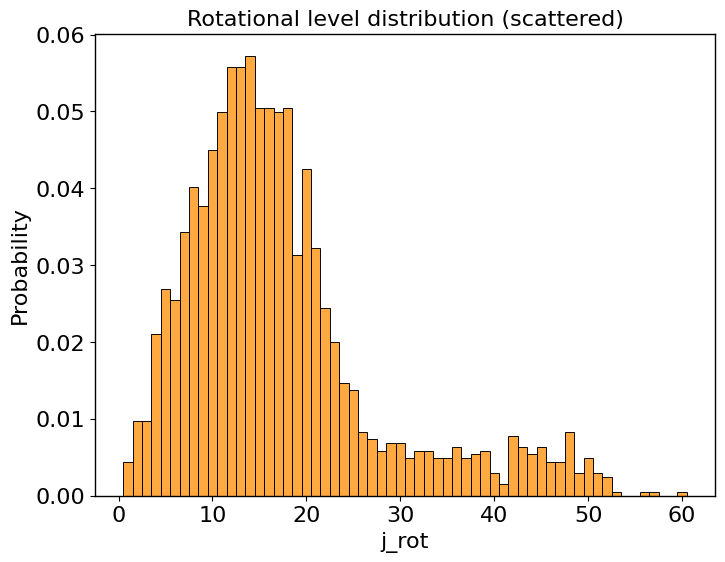

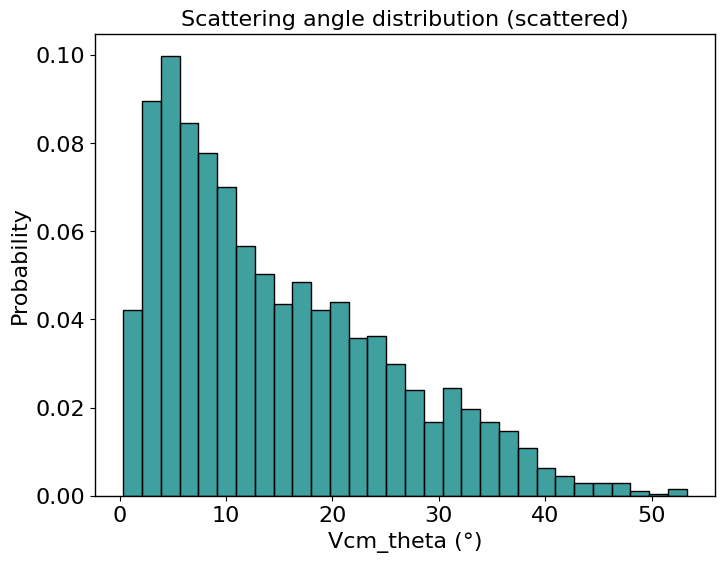

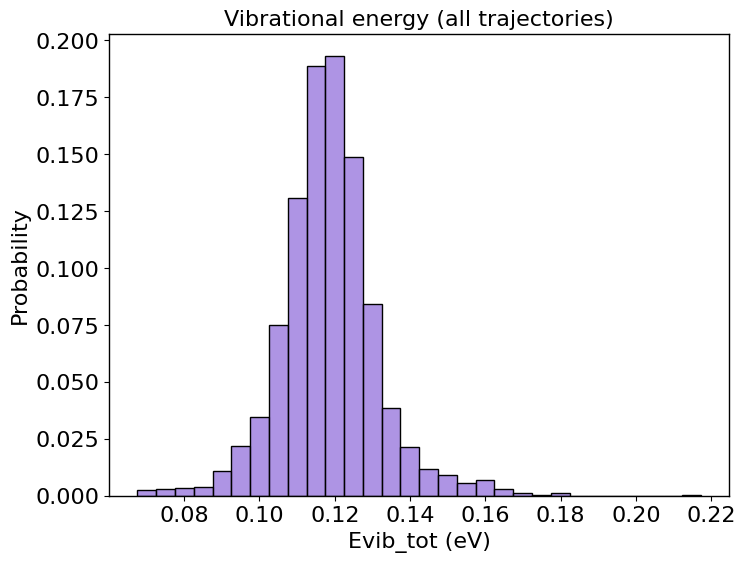

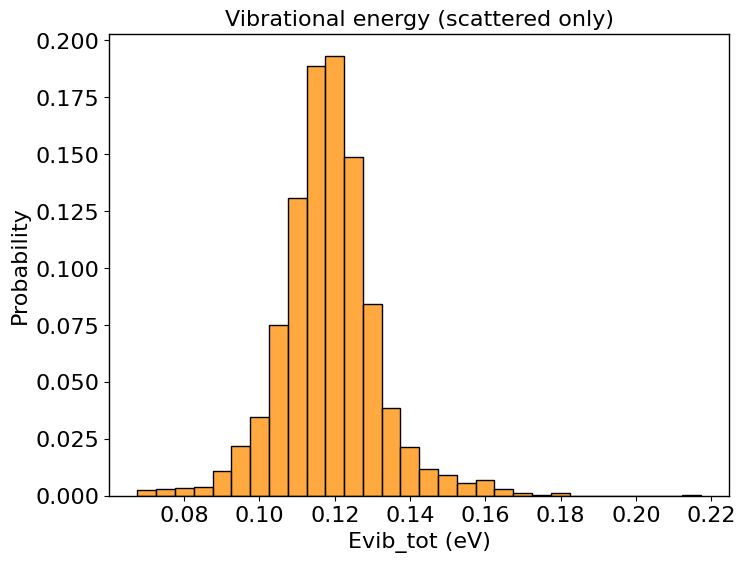

No samples for Vibrational energy (adsorbed only)


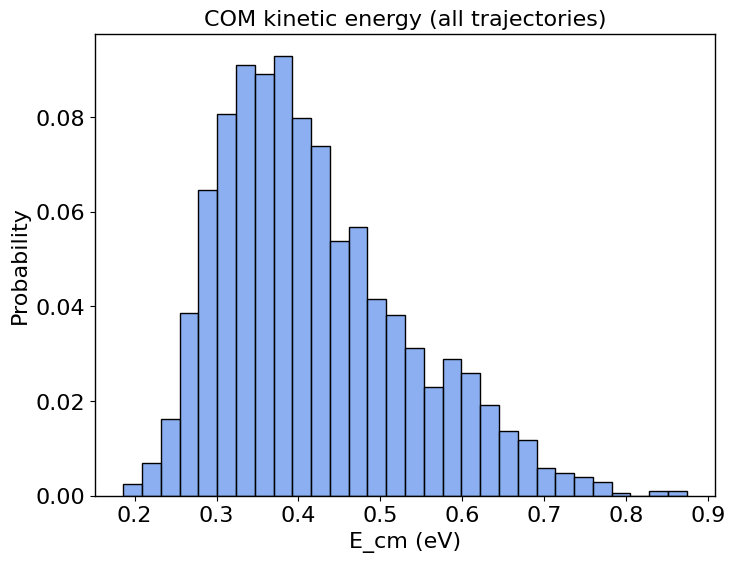

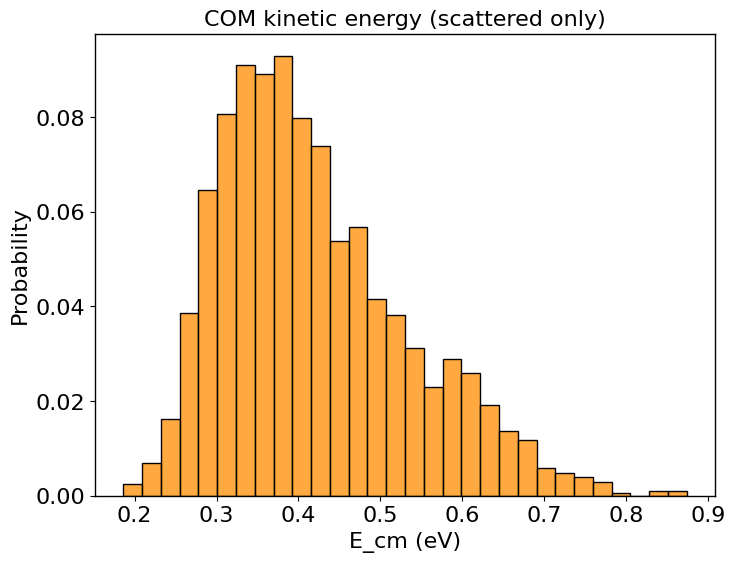

No samples for COM kinetic energy (adsorbed only)


In [14]:
# %% Loop over all trajectories + requested distributions (+ COM kinetic energy)
summaries = []

# collectors
n_total = 0
n_scattered = 0
j_scattered = []
theta_scattered = []
evib_all, evib_scattered, evib_adsorbed = [], [], []

# COM kinetic energy (eV)
Kcm_all, Kcm_scattered, Kcm_adsorbed = [], [], []

# if Ecm(eV) is absent, optionally compute from Vcm and total mass (amu)
total_mass_amu = None  # set e.g. 30.006 for NO; leave None to skip fallback

for path in tqdm.tqdm(files):
    df = pd.read_csv(path)
    if format == "VASP":
        df = df.iloc[1:].reset_index(drop=True)
    if "t_idx" not in df.columns or "COM_z-ztop(Å)" not in df.columns:
        print(f"Skipping {path.name} (missing columns)")
        continue

    n_total += 1

    t   = df["t_idx"].to_numpy()
    z   = df["COM_z-ztop(Å)"].to_numpy()
    dNO = df.get("d_NO(Å)", pd.Series(np.nan, index=df.index)).to_numpy()
    Ecm = df.get("Ecm(eV)",  pd.Series(np.nan, index=df.index)).to_numpy()
    Evib_tot = df.get("Evib_tot(eV)", pd.Series(np.nan, index=df.index)).to_numpy()
    Erot = df.get("Erot(eV)", pd.Series(np.nan, index=df.index)).to_numpy()

    # prefer explicit flag column; fall back to geometric threshold
    flag_col = "outcome" if "outcome" in df.columns else ("output" if "output" in df.columns else None)
    if flag_col is not None:
        flags = df[flag_col].to_numpy()
        scattered = np.any(flags == 1)
        first_scatter = int(np.argmax(flags == 1)) if scattered else None
    else:
        geo = (z >= scatter_z)
        scattered = bool(geo.any())
        first_scatter = int(np.argmax(geo)) if scattered else None

    # ----- summary table -----
    summaries.append({
        "file": path.name,
        "n_frames": len(df),
        "scattered": bool(scattered),
        "first_scatter_idx": first_scatter,
        "mean_z": float(np.nanmean(z)),
        "max_z": float(np.nanmax(z)),
        "mean_Ecm": float(np.nanmean(Ecm)),
        "mean_Evib": float(np.nanmean(Evib_tot)),
        "mean_Erot": float(np.nanmean(Erot)),
    })

    # ----- index to sample for distributions -----
    if scattered:
        n_scattered += 1
        i = first_scatter
        if "j_rot" in df.columns and pd.notna(df.loc[i, "j_rot"]):
            j_scattered.append(float(df.loc[i, "j_rot"]))
        if "Vcm_theta(°)" in df.columns and pd.notna(df.loc[i, "Vcm_theta(°)"]):
            theta_scattered.append(float(df.loc[i, "Vcm_theta(°)"]))
        if pd.notna(df.loc[i, "Evib_tot(eV)"]):
            ev = float(df.loc[i, "Evib_tot(eV)"])
            evib_scattered.append(ev); evib_all.append(ev)
        if "Ecm(eV)" in df.columns and pd.notna(df.loc[i, "Ecm(eV)"]):
            kc = float(df.loc[i, "Ecm(eV)"])
        elif total_mass_amu is not None and {"Vcm_x(Å/fs)","Vcm_y(Å/fs)","Vcm_z(Å/fs)"} <= set(df.columns):
            vx, vy, vz = df.loc[i, ["Vcm_x(Å/fs)","Vcm_y(Å/fs)","Vcm_z(Å/fs)"]].to_numpy(dtype=float)
            v = np.sqrt(vx*vx + vy*vy + vz*vz) * 1e5
            kc = 0.5 * (total_mass_amu*1.66053906660e-27) * v*v / 1.602176634e-19
        else:
            kc = np.nan
        Kcm_scattered.append(kc); Kcm_all.append(kc)
    else:
        i = len(df) - 1
        #if "j_rot" in df.columns and pd.notna(df.loc[i, "j_rot"]):
        #    j_scattered.append(float(df.loc[i, "j_rot"]))
        if "Evib_tot(eV)" in df.columns and pd.notna(df.loc[i, "Evib_tot(eV)"]):
            ev = float(df.loc[i, "Evib_tot(eV)"])
            evib_adsorbed.append(ev); evib_all.append(ev)
        if "Ecm(eV)" in df.columns and pd.notna(df.loc[i, "Ecm(eV)"]):
            kc = float(df.loc[i, "Ecm(eV)"])
        elif total_mass_amu is not None and {"Vcm_x(Å/fs)","Vcm_y(Å/fs)","Vcm_z(Å/fs)"} <= set(df.columns):
            vx, vy, vz = df.loc[i, ["Vcm_x(Å/fs)","Vcm_y(Å/fs)","Vcm_z(Å/fs)"]].to_numpy(dtype=float)
            v = np.sqrt(vx*vx + vy*vy + vz*vz) * 1e5
            kc = 0.5 * (total_mass_amu*1.66053906660e-27) * v*v / 1.602176634e-19
        else:
            kc = np.nan
        Kcm_adsorbed.append(kc); Kcm_all.append(kc)

# %% Combine all summaries
summary_df = pd.DataFrame(summaries)
print("\nSummary table:")
#display(summary_df)

# %% Seaborn-based global overview plots
# plt.figure(figsize=(7, 4))
# sns.histplot(summary_df["max_z"], bins=20, kde=False, color="steelblue")
# plt.xlabel("Max COM_z-ztop (Å)"); plt.ylabel("Count")
# plt.title("Distribution of max COM heights across runs")
# plt.show()

# sns.scatterplot(data=summary_df, x="mean_Ecm", y="mean_Evib",
#                 hue="max_z", palette="viridis", edgecolor=None)
# plt.colorbar = plt.colorbar
# plt.xlabel("Mean Ecm (eV)"); plt.ylabel("Mean Evib (eV)")
# plt.title("Energy correlation across runs")
# plt.tight_layout(); plt.show()

# %% Scattering probability
p_scat = n_scattered / n_total if n_total else np.nan
print(f"Scattering probability = {p_scat:.3f}  ({n_scattered}/{n_total})")

# Rotational level distribution (scattered)
if j_scattered:
    j_arr = np.asarray(j_scattered, float)
    sns.histplot(j_arr, bins=np.arange(np.floor(j_arr.min())-0.5, np.ceil(j_arr.max())+1.5, 1),
                 kde=False, color="darkorange", stat='probability')
    plt.xlabel("j_rot"); plt.ylabel("Probability")
    plt.title("Rotational level distribution (scattered)")
    plt.show()
else:
    print("No j_rot samples for scattered molecules.")

# Scattering angle from Vcm_theta (scattered)
if theta_scattered:
    th = np.asarray(theta_scattered, float)
    sns.histplot(th, bins=30, kde=False, color="teal", stat='probability')
    plt.xlabel("Vcm_theta (°)"); plt.ylabel("Probability")
    plt.title("Scattering angle distribution (scattered)")
    plt.show()
else:
    print("No Vcm_theta samples for scattered molecules.")

# Vibrational and COM kinetic energy distributions

_sns_hist(evib_all,       "Vibrational energy (all trajectories)",       "Evib_tot (eV)", "mediumpurple")
_sns_hist(evib_scattered, "Vibrational energy (scattered only)",         "Evib_tot (eV)", "darkorange")
_sns_hist(evib_adsorbed,  "Vibrational energy (adsorbed only)",          "Evib_tot (eV)", "gray")

_sns_hist(Kcm_all,        "COM kinetic energy (all trajectories)",       "E_cm (eV)", "cornflowerblue")
_sns_hist(Kcm_scattered,  "COM kinetic energy (scattered only)",         "E_cm (eV)", "darkorange")
_sns_hist(Kcm_adsorbed,   "COM kinetic energy (adsorbed only)",          "E_cm (eV)", "gray")